<a href="https://colab.research.google.com/github/esnue/ThesisAllocationSystem/blob/main/Zero_shot_topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Zero-shot topic modeling with ZeroShotTM


We are going to use our **Zero-Shot Topic Model** to get the topics out of the collection of academic papers we have for all Hertie School supervisor. 

## Topic Models 

Topic models allow you to discover latent topics in your documents in a completely unsupervised way. Just use your documents and get topics out.

## Contextualized Topic Models

What are Contextualized Topic Models? **CTMs** are a family of topic models that combine the expressive power of BERT embeddings with the unsupervised capabilities of topic models to get topics out of documents.


# Enabling the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

[Reference](https://colab.research.google.com/notebooks/gpu.ipynb)

# Installing Contextualized Topic Models

First, we install the contextualized topic model library

In [1]:
%%capture
!pip install contextualized-topic-models
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -U tqdm

## Restart the Notebook

For the changes to take effect, we now need to restart the notebook.

From the Menu:

Runtime → Restart Runtime

# Data

We are going to need some data. You should upload a file with one document per line. We assume you haven't run any preprocessing script.

However, if you want to first test the model without uploading your data, you can simply use the test file I'm putting here

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

file = pd.read_csv("/content/drive/MyDrive/ThesisAllocationSystem/data_final/train-papers-final.csv")
#transform content column row values into a list
text_file = file['Content'][1:].values.tolist()

print(text_file[5])
print(type(text_file))

b"Public Administration Reform in Europe  \n\nViews and Experiences from Senior Executives in 10 Countries \n\n \nWP3 Cross-national Report as part of the COCOPS Research Project \n\n \n\n  \n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\nGerhard Hammerschmid \nSteven Van de Walle \n\nRhys Andrews \nPhilippe Bezes \nAnja G\xf6rnitz \nAnca Oprisor \n\nVid timac \n\n \n\nJuly 2013 \n\n \n\n \n\n \n\n \n\n \n\nCoordination for Cohesion in the Public Sector of the Future (COCOPS): www.cocops.eu \n\n  \n\n \n\nhttp://www.cocops.eu/\n\n\nCOCOPS Work Package 3  Cross-national Report, July 2013 Page 2 \n\nAbout COCOPS \n\nThe COCOPS project (Coordinating for Cohesion in the Public Sector of the Future) seeks to \n\ncomparatively and quantitatively assess the impact of New Public Management-style reforms in \n\nEuropean countries, drawing on a team of European public administration scholars from 11 \n\nuniversities in 10 countries. It analyses the impact of reforms i

# Importing what we need

In [5]:
from contextualized_topic_models.models.ctm import ZeroShotTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing
import nltk

## Preprocessing

Why do we use the **preprocessed text** here? We need text without punctuation to build the bag of word. Also, we might want only to have the most frequent words inside the BoW. Too many words might not help.

In [6]:
nltk.download('stopwords')

documents = text_file
#documents = [line.strip() for line in open(text_file, encoding="utf-8").readlines()]
sp = WhiteSpacePreprocessing(documents, stopwords_language='english')
preprocessed_documents, unpreprocessed_corpus, vocab = sp.preprocess()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
preprocessed_documents[:10]

['nsee discussions author publication https www researchgate net publication incentive preferences issues strategies local government first evidence narticle authors including nsome authors publication also working related projects open innovative governments view project public sector future view project publications nsee profile school governance publications nsee profile nall content following page september nthe user downloaded nhttps www researchgate net publication motivation incentive preferences issues strategies local government first evidence austria enrichid rgreq xxx enrichsource el esc publicationcoverpdf nhttps www researchgate net publication motivation incentive preferences issues strategies local government first evidence austria enrichid rgreq xxx enrichsource el esc publicationcoverpdf nhttps www researchgate net project open innovative governments enrichid rgreq xxx enrichsource el esc publicationcoverpdf nhttps www researchgate net project public sector future enri

Stopwords coming from layout, publisher etc still in there. Authors names as well 

We don't discard the non-preprocessed texts, because we are going to use them as input for obtaining the contextualized document representations. 

Let's pass our files with preprocess and unpreprocessed data to our `TopicModelDataPreparation` object. This object takes care of creating the bag of words for you and of obtaining the contextualized BERT representations of documents. This operation allows us to create our training dataset. 

In [8]:
#Note: Here we use the contextualized model "distiluse-base-multilingual-cased", because we need a multilingual model for performing cross-lingual predictions later. Maybe switch to English at a later point (bert-base-nli-mean-tokens)
tp = TopicModelDataPreparation("distiluse-base-multilingual-cased")

training_dataset = tp.create_training_set(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

100%|██████████| 504M/504M [00:13<00:00, 36.8MB/s]


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Let's check the first thirty words of the vocabulary 

In [9]:
tp.vocab[:30]

['ability',
 'able',
 'absence',
 'ac',
 'academic',
 'accepted',
 'access',
 'according',
 'account',
 'accountability',
 'accounting',
 'accounts',
 'achieve',
 'achieved',
 'across',
 'act',
 'action',
 'actions',
 'active',
 'activities',
 'activity',
 'actor',
 'actors',
 'actual',
 'actually',
 'ad',
 'adaptation',
 'added',
 'addition',
 'additional']

## Training our Zero-Shot Contextualized Topic Model

Finally, we can fit our new topic model. We will ask the model to find 50 topics in our collection (n_component parameter of the CTM object).

In [10]:
ctm = ZeroShotTM(input_size=len(tp.vocab), bert_input_size=512, n_components=50, num_epochs=15)
ctm.fit(training_dataset) # run the model


Epoch: [15/15]	 Seen Samples: [12150/12150]	Train Loss: 13814.314814814816	Time: 0:00:00.488618: : 15it [00:07,  1.95it/s]


# Topics

After training, now it is the time to look at our topics: we can use the 

```
get_topic_lists
```

function to get the topics. It also accepts a parameter that allows you to select how many words you want to see for each topic.

In [17]:
ctm.get_topic_lists(5)

[['cause', 'respective', 'ninternational', 'finds', 'received'],
 ['germany', 'vet', 'study', 'german', 'focuses'],
 ['well', 'policy', 'economic', 'human', 'paper'],
 ['impact', 'compromise', 'review', 'pippidi', 'emotion'],
 ['fertility', 'www', 'content', 'europe', 'working'],
 ['effectively', 'known', 'frequently', 'know', 'reasons'],
 ['ai', 'data', 'words', 'research', 'related'],
 ['like', 'introduced', 'provision', 'discussions', 'comparing'],
 ['firms', 'price', 'explained', 'following', 'exists'],
 ['financial', 'firms', 'higher', 'productivity', 'open'],
 ['century', 'known', 'advantage', 'well', 'matter'],
 ['et', 'al', 'firms', 'public', 'policy'],
 ['collective', 'past', 'cultural', 'capital', 'german'],
 ['value', 'data', 'estimates', 'survey', 'models'],
 ['et', 'power', 'income', 'al', 'variables'],
 ['economic', 'demand', 'survey', 'firms', 'higher'],
 ['policy', 'political', 'org', 'www', 'financial'],
 ['literature', 'system', 'content', 'legitimacy', 'social'],
 ['

### Let's predict the topics of the training documents 

Ok now we can take a document and see which topic has been assigned to it. Results will obviously change with respect to the documents you are using. For example, let's predict the topic of the tenth preprocessed document.

In [11]:
topics_predictions = ctm.get_doc_topic_distribution(training_dataset, n_samples=5) # get all the topic predictions

Sampling: [5/5]: : 5it [00:02,  2.17it/s]


In [12]:
preprocessed_documents[10] # see the text of our first preprocessed document

'nsocial na comparative overview npublic administration general employment social affairs inclusion developing better country knowledge public administration institutional building neuropean commission general employment social affairs inclusion investment policy legislation unit eu neuropean commission nb nmailto unit eu neuropean commission general employment social affairs inclusion developing better country knowledge public administration institutional building na comparative overview npublic administration neuropean commission general employment social affairs inclusion developing better country knowledge public administration institutional building nthis document european commission however views commission cannot held responsible use may made information nmore information european union available internet http www eu publications office european union ndoi european union direct service help find nto questions european union number information given free calls though may nhttp eu

In [13]:
import numpy as np
topic_number = np.argmax(topics_predictions[10]) # get the topic id of the tenth document
topic_number

48

In [14]:
ctm.get_topic_lists(10)[topic_number] #and the topic should be about public management related things

['law',
 'european',
 'und',
 'firms',
 'many',
 'open',
 'world',
 'data',
 'governments',
 'www']

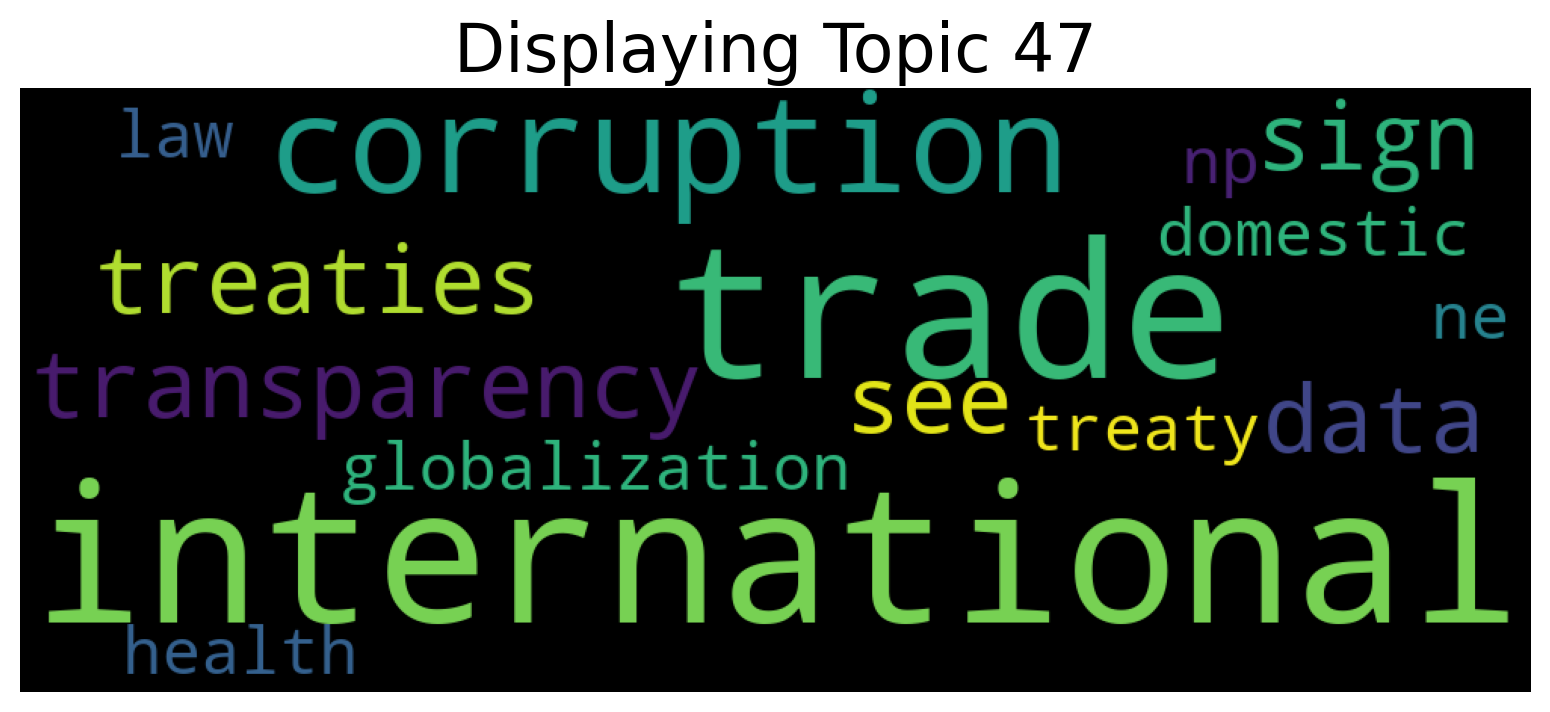

In [15]:
ctm.get_wordcloud(topic_id=47, n_words=15)

## Evaluation

In [16]:
from contextualized_topic_models.evaluation.measures import CoherenceNPMI

#with train_preprocessed_documents_for_bow as fr:
texts = [line.split() for line in preprocessed_documents] # load text for NPMI

npmi = CoherenceNPMI(texts=texts, topics=ctm.get_topic_lists(10))
npmi.score()

/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


-0.0576747893108484